In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import xarray as xr
import rioxarray as rxr
import rasterio as rio
import rasterstats as rstats
import regionmask
import os
import re

In [2]:
source_dir = '/mnt/c/Users/natra/Documents/Research/Iraq-post-conflict-rebel-governance'
iom_adm3_mapping = source_dir + '/data/iom/iom_adm3_mapping.csv'
iom_data_file = source_dir + '/data/iom/iom_raw.xlsx'
ag_indices_file = source_dir + '/data/satellite_indices/evi/evi_mask_mean_max_min/evi_stats_Jan2001-Dec2022.csv'
berman_ethnicity_file = source_dir + "/data/berman_etal/esoc-iraq-v3_ethnicity.csv"

In [3]:
iom_adm3_map = pd.read_csv(iom_adm3_mapping)
iom_data = pd.read_excel(iom_data_file, sheet_name="Full Dataset",header=1)
ag_data = pd.read_csv(ag_indices_file)
berman_eth = pd.read_csv(berman_ethnicity_file)

## UCDP Conflict Events

In [4]:
ucdp_iraq_file = source_dir + '/data/conflict/gedevents-Iraq-2024-04-12.csv'
ucdp_conflict = pd.read_csv(ucdp_iraq_file)
print(ucdp_conflict.columns)
print(ucdp_conflict.shape)
ucdp_conflict.head(2)

Index(['id', 'relid', 'year', 'active_year', 'code_status', 'type_of_violence',
       'conflict_dset_id', 'conflict_new_id', 'conflict_name', 'dyad_dset_id',
       'dyad_new_id', 'dyad_name', 'side_a_dset_id', 'side_a_new_id', 'side_a',
       'side_b_dset_id', 'side_b_new_id', 'side_b', 'number_of_sources',
       'source_article', 'source_office', 'source_date', 'source_headline',
       'source_original', 'where_prec', 'where_coordinates',
       'where_description', 'adm_1', 'adm_2', 'latitude', 'longitude',
       'geom_wkt', 'priogrid_gid', 'country', 'country_id', 'region',
       'event_clarity', 'date_prec', 'date_start', 'date_end', 'deaths_a',
       'deaths_b', 'deaths_civilians', 'deaths_unknown', 'best_est',
       'high_est', 'low_est'],
      dtype='object')
(8713, 47)


,id,relid,year,active_year,code_status,type_of_violence,conflict_dset_id,conflict_new_id,conflict_name,dyad_dset_id,...,date_prec,date_start,date_end,deaths_a,deaths_b,deaths_civilians,deaths_unknown,best_est,high_est,low_est
0,121766,IRQ-2003-1-332-21,2003,True,Clear,1,420,420,"Australia, United Kingdom, United States - Iraq",883,...,1,3/24/2003 0:00,3/24/2003 0:00,0,0,0,0,0,62,0
1,121767,IRQ-2003-1-332-23,2003,True,Clear,1,420,420,"Australia, United Kingdom, United States - Iraq",883,...,1,3/25/2003 0:00,3/25/2003 0:00,0,4,0,0,4,4,4


In [9]:
ucdp_conflict_events.side_b.unique()

array(['Government of Iraq', 'PUK', 'al-Mahdi Army', 'IS', 'Civilians',
       'PKK', 'Ansar al-Islam', 'RJF', 'KDPI', 'SCIRI', 'PJAK', 'MEK',
       'JRTN', 'Government of Israel', 'Syrian insurgents'], dtype=object)

In [10]:
ucdp_conflict_events = ucdp_conflict.loc[:,('id', 'relid', 'year','type_of_violence',
                                            'conflict_new_id', 'conflict_name',
                                            'side_a_new_id', 'side_a',
                                            'side_b_new_id', 'side_b', 'number_of_sources',
                                            'where_prec', 'where_coordinates','where_description', 
                                             'latitude', 'longitude',
                                            'event_clarity', 'date_prec', 'date_start', 'date_end',
                                            'deaths_a','deaths_b','deaths_civilians','deaths_unknown')]
ucdp_conflict_events = ucdp_conflict_events[ucdp_conflict_events['year']>= 2000]
ucdp_conflict_events.loc[:,'total_deaths'] = ucdp_conflict_events['deaths_a'] + ucdp_conflict_events['deaths_b'] + ucdp_conflict_events['deaths_civilians'] + ucdp_conflict_events['deaths_unknown']  
ucdp_conflict_events.loc[:,'civ_violence'] = np.where(ucdp_conflict_events['side_b']=='Civilians',1,0)
ucdp_conflict_events = ucdp_conflict_events.drop(columns=['deaths_a','deaths_b','deaths_unknown'])
ucdp_conflict_events.head(2)

,id,relid,year,type_of_violence,conflict_new_id,conflict_name,side_a_new_id,side_a,side_b_new_id,side_b,...,where_description,latitude,longitude,event_clarity,date_prec,date_start,date_end,deaths_civilians,total_deaths,civ_violence
0,121766,IRQ-2003-1-332-21,2003,1,420,"Australia, United Kingdom, United States - Iraq",3822,"Government of Australia, Government of United ...",116,Government of Iraq,...,Iraq,33.000000,44.000000,1,1,3/24/2003 0:00,3/24/2003 0:00,0,0,0
1,121767,IRQ-2003-1-332-23,2003,1,420,"Australia, United Kingdom, United States - Iraq",3822,"Government of Australia, Government of United ...",116,Government of Iraq,...,Euphrates River,33.083333,43.483333,1,1,3/25/2003 0:00,3/25/2003 0:00,0,4,0


In [11]:
ucdp_isis_events = ucdp_conflict_events[(ucdp_conflict_events['side_a']=='IS')|(ucdp_conflict_events['side_b']=='IS')]
ucdp_conflict_events['isis_conflict'] = np.where(((ucdp_conflict_events['side_a']=='IS')|(ucdp_conflict_events['side_b']=='IS')),
                                                 1,0)
print(ucdp_conflict_events[ucdp_conflict_events['isis_conflict']==1].shape)
ucdp_conflict_events['date_start'] = pd.to_datetime(ucdp_conflict_events['date_start'])
ucdp_conflict_events['date_end'] = pd.to_datetime(ucdp_conflict_events['date_end'])
ucdp_conflict_events['geometry'] = gpd.points_from_xy(ucdp_conflict_events.longitude,ucdp_conflict_events.latitude)
ucdp_conflict_events = gpd.GeoDataFrame(ucdp_conflict_events, geometry=ucdp_conflict_events['geometry'],
                                        crs='epsg:4326')
ucdp_isis_events.head(2)

(6813, 24)


,id,relid,year,type_of_violence,conflict_new_id,conflict_name,side_a_new_id,side_a,side_b_new_id,side_b,...,where_description,latitude,longitude,event_clarity,date_prec,date_start,date_end,deaths_civilians,total_deaths,civ_violence
9,131191,IRQ-2006-1-448-233,2006,1,259,Iraq: Government,116,Government of Iraq,234,IS,...,Mosul town,36.335,43.118889,1,1,8/17/2006 0:00,8/17/2006 0:00,0,1,0
10,131192,IRQ-2006-1-448-396,2006,1,259,Iraq: Government,116,Government of Iraq,234,IS,...,Anbar province,33.000,41.750000,1,1,12/24/2006 0:00,12/24/2006 0:00,0,2,0


In [12]:
# join ucdp to adm3 areas
iraq_shp_adm3_loc = source_dir + '/data/geo_boundaries/irq-administrative-divisions-shapefiles/irq_admbnda_adm3_cso_20190603.shp'
iraq_shp_adm3 = gpd.read_file(iraq_shp_adm3_loc)
iraq_adm3_filt = iraq_shp_adm3.loc[:,('ADM1_EN','ADM2_EN','ADM3_EN','geometry')]


In [13]:
print(ucdp_conflict_events.shape)
ucdp_adm3_geoms = gpd.sjoin(ucdp_conflict_events,iraq_adm3_filt,how='left',predicate='intersects')
print(ucdp_adm3_geoms.shape)

(8260, 25)
(8260, 29)


In [14]:
# based on event location precision, assign locations at adm 3 level with possibility to remove less precise
ucdp_adm3_geoms_wh12 = ucdp_adm3_geoms[ucdp_adm3_geoms['where_prec'].isin([1,2])]
ucdp_adm3_geoms_wh12 = ucdp_adm3_geoms_wh12.drop(columns=['ADM1_EN','ADM2_EN','index_right'])
print(ucdp_adm3_geoms_wh12.shape)
ucdp_adm3_geoms_wh3 = ucdp_adm3_geoms[ucdp_adm3_geoms['where_prec'] == 3]
print(ucdp_adm3_geoms_wh3.shape)
ucdp_adm3_geoms_wh4 = ucdp_adm3_geoms[ucdp_adm3_geoms['where_prec'] == 4]
print(ucdp_adm3_geoms_wh4.shape)


(6867, 26)
(278, 29)
(593, 29)


In [15]:
# join adm2 level with all adm3
iraq_adm3_filt_adm2 = iraq_adm3_filt.loc[:,('ADM2_EN','ADM3_EN')]
ucdp_adm3_geoms_wh3 = ucdp_adm3_geoms_wh3.drop(columns=['index_right','ADM1_EN','ADM3_EN'])
print(ucdp_adm3_geoms_wh3.shape)
ucdp_adm3_geoms_wh3_adm3 = ucdp_adm3_geoms_wh3.merge(iraq_adm3_filt_adm2,how='left',on='ADM2_EN')
ucdp_adm3_geoms_wh3_adm3 = ucdp_adm3_geoms_wh3_adm3.drop(columns=['ADM2_EN'])
print(ucdp_adm3_geoms_wh3_adm3.shape)

(278, 26)
(992, 26)


In [16]:
# join adm1 level with all adm3
iraq_adm3_filt_adm1 = iraq_adm3_filt.loc[:,('ADM1_EN','ADM3_EN')]
ucdp_adm3_geoms_wh4 = ucdp_adm3_geoms_wh4.drop(columns=['index_right','ADM2_EN','ADM3_EN'])
print(ucdp_adm3_geoms_wh4.shape)
ucdp_adm3_geoms_wh4_adm3 = ucdp_adm3_geoms_wh4.merge(iraq_adm3_filt_adm1,how='left',on='ADM1_EN')
ucdp_adm3_geoms_wh4_adm3 = ucdp_adm3_geoms_wh4_adm3.drop(columns=['ADM1_EN'])
print(ucdp_adm3_geoms_wh4_adm3.shape)

(593, 26)
(11973, 26)


In [17]:
# combine ucdp conflict events where location can be geocoded to at least adm 1
ucdp_conflict_locknown = pd.concat([ucdp_adm3_geoms_wh12,ucdp_adm3_geoms_wh3_adm3,
                                    ucdp_adm3_geoms_wh4_adm3])
ucdp_conflict_locknown = ucdp_conflict_locknown.drop(columns=['geometry','latitude','longitude',
                                                              'where_coordinates','date_start'])



In [18]:
ucdp_conflict_loc_monthly =  ucdp_conflict_locknown.set_index('date_end')
ucdp_conflict_loc_monthly = ucdp_conflict_loc_monthly.groupby(['ADM3_EN','where_prec','isis_conflict','civ_violence'])[['relid']].resample('ME').count()
ucdp_conflict_loc_monthly = ucdp_conflict_loc_monthly.reset_index()
ucdp_conflict_loc_monthly = ucdp_conflict_loc_monthly.rename(columns={'date_end':'month',
                                                                      'relid':'num_events'})
ucdp_conflict_loc_monthly = ucdp_conflict_loc_monthly[ucdp_conflict_loc_monthly['num_events']>0]
ucdp_conflict_loc_monthly.head()

,ADM3_EN,where_prec,isis_conflict,civ_violence,month,num_events
0,Abi Gharaq,4,1,0,2013-06-30,1
5,Abi Gharaq,4,1,0,2013-11-30,1
12,Abi Gharaq,4,1,0,2014-06-30,1
13,Abi Gharaq,4,1,0,2014-07-31,1
14,Abi Gharaq,4,1,1,2013-06-30,1


In [19]:
ucdp_monthly_file = source_dir + '/data/conflict/ucdp_conflict_monthly.csv'
ucdp_conflict_loc_monthly.to_csv(ucdp_monthly_file,index=False)

In [20]:
ucdp_conflict_events['side_a'].unique()

array(['Government of Australia, Government of United Kingdom, Government of United States of America',
       'Ansar al-Islam', 'Government of Iraq', 'IS',
       'Government of Turkey', '1920 Revolution Brigades',
       'al-Mahdi Army', 'Government of Iran', 'Jaysh al-Mukhtar', 'KDP',
       'PKK', 'Government of Syria', 'AAH', 'Jamaat Jund al-Sahaba'],
      dtype=object)

In [21]:
ucdp_conflict_events['side_b'].unique()

array(['Government of Iraq', 'PUK', 'al-Mahdi Army', 'IS', 'Civilians',
       'PKK', 'Ansar al-Islam', 'RJF', 'KDPI', 'SCIRI', 'PJAK', 'MEK',
       'JRTN', 'Government of Israel', 'Syrian insurgents'], dtype=object)

## xSub Data - Monthly Conflict Events

In [21]:
xsub_conflict_file = source_dir + '/data/conflict/xSub_MELTT1km2dB_IRQ_event.csv'
xsub_conflict = pd.read_csv(xsub_conflict_file)
print(xsub_conflict.columns)
xsub_conflict.head(2)

Index(['SOURCE', 'CONFLICT', 'COWN', 'COWC', 'ISO3', 'DATE', 'LAT', 'LONG',
       'GEOPRECISION', 'TIMEPRECISION', 'INITIATOR_SIDEA', 'INITIATOR_SIDEB',
       'INITIATOR_SIDEC', 'INITIATOR_SIDED', 'TARGET_SIDEA', 'TARGET_SIDEB',
       'TARGET_SIDEC', 'TARGET_SIDED', 'DYAD_A_A', 'DYAD_A_B', 'DYAD_A_C',
       'DYAD_A_D', 'DYAD_B_A', 'DYAD_B_B', 'DYAD_B_C', 'DYAD_B_D', 'DYAD_C_A',
       'DYAD_C_B', 'DYAD_C_C', 'DYAD_C_D', 'DYAD_D_A', 'DYAD_D_B', 'DYAD_D_C',
       'DYAD_D_D', 'ACTION_ANY', 'ACTION_IND', 'ACTION_DIR', 'ACTION_PRT',
       'SIDEA_ANY', 'SIDEA_IND', 'SIDEA_DIR', 'SIDEA_PRT', 'SIDEB_ANY',
       'SIDEB_IND', 'SIDEB_DIR', 'SIDEB_PRT', 'SIDEC_ANY', 'SIDEC_IND',
       'SIDEC_DIR', 'SIDEC_PRT', 'SIDED_ANY', 'SIDED_IND', 'SIDED_DIR',
       'SIDED_PRT', 'ACTION_AIRSTRIKE', 'ACTION_AMBUSH', 'ACTION_ARMOR',
       'ACTION_ARREST', 'ACTION_ARTILLERY', 'ACTION_BOMB', 'ACTION_CHEMICAL',
       'ACTION_CIV_ABUSE', 'ACTION_DISPLACE', 'ACTION_FIREFIGHT',
       'ACTION_KIDNAP', 'ACT

,SOURCE,CONFLICT,COWN,COWC,ISO3,DATE,LAT,LONG,GEOPRECISION,TIMEPRECISION,...,ACTION_RAID,ACTION_RIOT,ACTION_RIOTCONTROL,ACTION_ROBBERY,ACTION_ROCKET,ACTION_SIEGE,ACTION_STORM,ACTION_SUICIDE,ACTION_TERROR,ACTION_UNKNOWN
0,MELTT1km2dB,Iraq,645,IRQ,IRQ,19910113,33.340582,44.400876,settlement,day,...,0,0,0,0,0,0,0,0,0,0
1,MELTT1km2dB,Iraq,645,IRQ,IRQ,19910117,33.340582,44.400876,settlement,day,...,0,0,0,0,0,0,0,0,0,0


In [23]:
xsub_conflict.loc[:,('DYAD_A_A', 'DYAD_A_B', 'DYAD_A_C',
       'DYAD_A_D', 'DYAD_B_A', 'DYAD_B_B', 'DYAD_B_C', 'DYAD_B_D', 'DYAD_C_A',
       'DYAD_C_B', 'DYAD_C_C', 'DYAD_C_D', 'DYAD_D_A', 'DYAD_D_B', 'DYAD_D_C',
       'DYAD_D_D')]

,DYAD_A_A,DYAD_A_B,DYAD_A_C,DYAD_A_D,DYAD_B_A,DYAD_B_B,DYAD_B_C,DYAD_B_D,DYAD_C_A,DYAD_C_B,DYAD_C_C,DYAD_C_D,DYAD_D_A,DYAD_D_B,DYAD_D_C,DYAD_D_D
0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51862,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
51863,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
51864,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
51865,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
xsub_tojoin = xsub_conflict.loc[:,('DATE','LAT','LONG','ACTION_IND', 'ACTION_DIR', 'ACTION_PRT')]
xsub_tojoin['date_dt'] = pd.to_datetime(xsub_tojoin['DATE'],format='%Y%m%d')
print(xsub_tojoin['date_dt'].max())
print(xsub_tojoin['date_dt'].min())

2019-12-07 00:00:00
1991-01-13 00:00:00


In [20]:
xsub_tojoin = xsub_conflict.loc[:,('DATE','LAT','LONG','ACTION_IND', 'ACTION_DIR', 'ACTION_PRT')]
xsub_tojoin['date_dt'] = pd.to_datetime(xsub_tojoin['DATE'],format='%Y%m%d')
xsub_tojoin = xsub_tojoin[xsub_tojoin['date_dt']>='2001-01-01']
xsub_tojoin['geometry'] = gpd.points_from_xy(xsub_tojoin['LONG'],xsub_tojoin['LAT'])
xsub_tojoin = xsub_tojoin.drop(columns=['LAT','LONG','DATE'])
xsub_tojoin = gpd.GeoDataFrame(xsub_tojoin, geometry='geometry',crs='EPSG:4326')

xsub_tojoin.head()

,ACTION_IND,ACTION_DIR,ACTION_PRT,date_dt,geometry
175,0,0,0,2001-04-18,POINT (45.17786 34.27725)
176,0,0,0,2001-06-07,POINT (47.79747 30.53302)
177,0,0,0,2001-09-16,POINT (47.14399 31.83588)
178,1,0,0,2001-09-16,POINT (47.17528 31.84528)
179,0,0,0,2001-09-23,POINT (46.01103 35.26622)


In [21]:
# join xsub to adm3 areas
iraq_shp_adm3_loc = source_dir + '/data/geo_boundaries/irq-administrative-divisions-shapefiles/irq_admbnda_adm3_cso_20190603.shp'
iraq_shp_adm3 = gpd.read_file(iraq_shp_adm3_loc)
iraq_adm3_filt = iraq_shp_adm3.loc[:,('ADM3_EN','ADM3_PCODE','geometry')]

adm3_xsub = xsub_tojoin.sjoin(iraq_adm3_filt, how='left', predicate='intersects')
print(xsub_tojoin.shape)
print(adm3_xsub.shape)
print(adm3_xsub[adm3_xsub['ADM3_PCODE'].isna()].shape) 
adm3_xsub.head(2)

(51692, 5)
(51692, 8)
(166, 8)


,ACTION_IND,ACTION_DIR,ACTION_PRT,date_dt,geometry,index_right,ADM3_EN,ADM3_PCODE
175,0,0,0,2001-04-18,POINT (45.17786 34.27725),149.0,Jalawla,IQG10Q05N04
176,0,0,0,2001-06-07,POINT (47.79747 30.53302),170.0,Markaz Al-Basrah,IQG02Q02N02


In [23]:
# from examination of fields that don't join, it seems some are mis-identified geometrically (eg, longitude 4.3)
# others are very close / along the border of Iraq, which should be included, but some others are far outside,
# in Iran or elsewhere. Will set a max distance to avoid this 
adm3_xsub[adm3_xsub['ADM3_PCODE'].isna()].head(8)

,ACTION_IND,ACTION_DIR,ACTION_PRT,date_dt,geometry,index_right,ADM3_EN,ADM3_PCODE
23906,1,0,0,2009-03-08,POINT (4.39389 33.33861),NaN,NaN,NaN
24054,1,0,0,2009-03-26,POINT (4.39389 33.33861),NaN,NaN,NaN
24210,1,1,0,2009-04-16,POINT (46.58972 33.38444),NaN,NaN,NaN
24694,1,0,0,2009-06-22,POINT (4.18500 33.30833),NaN,NaN,NaN
24764,1,0,0,2009-07-01,POINT (4.39222 35.46806),NaN,NaN,NaN
32116,1,0,0,2016-01-01,POINT (18.46667 33.42056),NaN,NaN,NaN
32193,0,1,0,2016-01-04,POINT (20.76667 32.88722),NaN,NaN,NaN
32239,0,1,0,2016-01-05,POINT (30.00000 36.08333),NaN,NaN,NaN


In [24]:
xsub_unjoined = adm3_xsub[adm3_xsub['ADM3_PCODE'].isna()]
xsub_unjoined = xsub_unjoined.drop(columns=['index_right','ADM3_EN','ADM3_PCODE'])
xsub_unjoined = xsub_unjoined.to_crs('EPSG:3893')

iraq_adm3_newcrs = iraq_adm3_filt.to_crs('EPSG:3893')

adm3_xsub_nn = xsub_unjoined.sjoin_nearest(iraq_adm3_newcrs, how='left',max_distance=10000)
adm3_xsub_nn = adm3_xsub_nn.to_crs('EPSG:4326')
print(xsub_unjoined.shape)
print(adm3_xsub_nn.shape)
# still 132 records which did not join within 10km of the Iraq shapefile edges, so will not include these
print(adm3_xsub_nn[adm3_xsub_nn['ADM3_PCODE'].isna()].shape) 
adm3_xsub_nn.head(2)

(166, 5)
(166, 8)
(132, 8)


,ACTION_IND,ACTION_DIR,ACTION_PRT,date_dt,geometry,index_right,ADM3_EN,ADM3_PCODE
23906,1,0,0,2009-03-08,POINT (4.39389 33.33861),NaN,NaN,NaN
24054,1,0,0,2009-03-26,POINT (4.39389 33.33861),NaN,NaN,NaN


In [26]:
adm3_xsub_nn_notna = adm3_xsub_nn[~adm3_xsub_nn['ADM3_PCODE'].isna()]
adm3_xsub_notna = adm3_xsub[~adm3_xsub['ADM3_PCODE'].isna()]

adm3_xsub_fin  = pd.concat([adm3_xsub_notna,adm3_xsub_nn_notna])
adm3_xsub_fin = adm3_xsub_fin.drop(columns=['index_right','geometry'])
adm3_xsub_fin.head(3)

,ACTION_IND,ACTION_DIR,ACTION_PRT,date_dt,ADM3_EN,ADM3_PCODE
175,0,0,0,2001-04-18,Jalawla,IQG10Q05N04
176,0,0,0,2001-06-07,Markaz Al-Basrah,IQG02Q02N02
177,0,0,0,2001-09-16,Al-Msharah,IQG14Q03N02


In [37]:
adm3_xsub_monthly =  adm3_xsub_fin.set_index('date_dt')
adm3_xsub_monthly = adm3_xsub_monthly.groupby(['ADM3_EN','ADM3_PCODE'])[['ACTION_IND','ACTION_DIR','ACTION_PRT']].resample('ME').sum()
adm3_xsub_monthly = adm3_xsub_monthly.reset_index()
adm3_xsub_monthly = adm3_xsub_monthly.rename(columns={'date_dt':'month'})
adm3_xsub_monthly.head()

,ADM3_EN,ADM3_PCODE,month,ACTION_IND,ACTION_DIR,ACTION_PRT
0,Abi Gharaq,IQG07Q02N02,2017-12-31,1,1,0
1,Abi Gharaq,IQG07Q02N02,2018-01-31,0,0,0
2,Abi Gharaq,IQG07Q02N02,2018-02-28,0,0,0
3,Abi Gharaq,IQG07Q02N02,2018-03-31,0,0,0
4,Abi Gharaq,IQG07Q02N02,2018-04-30,0,0,0


In [38]:
adm3_xsub_file = source_dir + '/data/conflict/adm3_xsub_monthly.csv'
adm3_xsub_monthly.to_csv(adm3_xsub_file,index=False)

## Ethnicity

### GeoEPR

In [6]:
geoepr_file = source_dir + '/data/EPR/GeoEPR-2021.geojson'
geoepr_df = gpd.read_file(geoepr_file)

In [7]:
geoepr_iraq = geoepr_df[geoepr_df['statename']=='Iraq']
geoepr_iraq

,gwid,statename,from,to,group,groupid,gwgroupid,umbrella,sqkm,type,geometry
1086,645,Iraq,1946,2021,Shi'a Arabs,2000,64502000,NaN,108150,Regional & urban,"MULTIPOLYGON (((45.38094 33.41709, 45.33382 33..."
1087,645,Iraq,1946,2021,Sunni Arabs,3000,64503000,NaN,96757,Regional & urban,"MULTIPOLYGON (((47.09444 29.90708, 47.04776 29..."
1088,645,Iraq,1946,2021,Kurds,1000,64501000,NaN,72420,Regional & urban,"MULTIPOLYGON (((43.91298 37.22659, 43.91298 37..."
1089,645,Iraq,1980,2021,Assyrians,4000,64504000,NaN,1000,Regionally based,"MULTIPOLYGON (((43.16741 37.12906, 43.20782 37..."
1090,645,Iraq,1992,2021,Turkmen,5000,64505000,NaN,2995,Regionally based,"MULTIPOLYGON (((44.85596 34.78855, 44.86303 34..."


In [8]:
iraq_shp_adm3_loc = source_dir + '/data/geo_boundaries/irq-administrative-divisions-shapefiles/irq_admbnda_adm3_cso_20190603.shp'
iraq_shp_adm3 = gpd.read_file(iraq_shp_adm3_loc)
iraq_adm3_filt = iraq_shp_adm3.loc[:,('ADM3_EN','ADM3_PCODE','geometry')]


In [12]:
epr_sunni = geoepr_iraq[geoepr_iraq['group']=='Sunni Arabs'].loc[:,('group','geometry')]
epr_non_sunni =geoepr_iraq[geoepr_iraq['group']!='Sunni Arabs'].loc[:,('group','geometry')]
epr_non_sunni = epr_non_sunni.dissolve()
epr_non_sunni['group'] = 'Non-Sunni Arabs'

In [36]:
iraq_adm3_filt_eth = iraq_adm3_filt.sjoin(epr_sunni,predicate='intersects',how='left')
iraq_adm3_filt_eth = iraq_adm3_filt_eth.drop(columns=['index_right'])
iraq_adm3_filt_eth = iraq_adm3_filt_eth.sjoin(epr_non_sunni, predicate='intersects',how='left')
iraq_adm3_filt_eth['sunni_dom'] = np.where((iraq_adm3_filt_eth['group_left']=='Sunni Arabs')&(iraq_adm3_filt_eth['group_right'].isna()),1,0)
iraq_adm3_filt_eth['sunni_mix'] = np.where((iraq_adm3_filt_eth['group_left']=='Sunni Arabs')&(iraq_adm3_filt_eth['group_right'] == 'Non-Sunni Arabs'),1,0)
iraq_adm3_filt_eth['no_sunni'] = np.where((iraq_adm3_filt_eth['group_left'].isna())&(iraq_adm3_filt_eth['group_right'] == 'Non-Sunni Arabs'),1,0)
iraq_adm3_filt_eth = iraq_adm3_filt_eth.drop(columns=['index_right','group_left','group_right','geometry'])
iraq_adm3_filt_eth.head()

,ADM3_EN,ADM3_PCODE,sunni_dom,sunni_mix,no_sunni
0,Abi Gharaq,IQG01Q05N01,0,0,1
1,Abu Dalf,IQG16Q01N02,1,0,0
2,Abu Ghraib,IQG08Q02N02,0,1,0
3,Agjalare,IQG06Q02N01,0,0,1
4,Akaika,IQG17Q05N04,0,0,1


In [32]:
# confirm no overlap in any fields
iraq_adm3_filt_eth[(iraq_adm3_filt_eth['sunni_dom']==1)&(iraq_adm3_filt_eth['sunni_mix']==1)]

,ADM3_EN,ADM3_PCODE,sunni_dom,sunni_mix,no_sunni


In [33]:
# confirm no overlap in any fields
iraq_adm3_filt_eth[(iraq_adm3_filt_eth['sunni_mix']==1)&(iraq_adm3_filt_eth['no_sunni']==1)]

,ADM3_EN,ADM3_PCODE,sunni_dom,sunni_mix,no_sunni


In [34]:
# confirm no overlap in any fields
iraq_adm3_filt_eth[(iraq_adm3_filt_eth['sunni_dom']==1)&(iraq_adm3_filt_eth['no_sunni']==1)]

,ADM3_EN,ADM3_PCODE,sunni_dom,sunni_mix,no_sunni


In [35]:
iraq_adm3_filt_eth_file = source_dir + '/data/EPR/adm3_sunni_epr.csv'
iraq_adm3_filt_eth.to_csv(iraq_adm3_filt_eth_file,index=False)

#### Create Adm 2 GeoEPR to compare with Berman et al.

In [15]:
iraq_adm2_filt = iraq_shp_adm3.loc[:,('ADM2_EN','ADM2_PCODE','geometry')]
iraq_adm2_filt = iraq_adm2_filt.dissolve(by=['ADM2_EN','ADM2_PCODE'])
iraq_adm2_filt = iraq_adm2_filt.reset_index()
iraq_adm2_filt.shape

(101, 3)

In [52]:
iraq_adm2_filt_eth = iraq_adm2_filt.sjoin(epr_sunni,predicate='intersects',how='left')
iraq_adm2_filt_eth = iraq_adm2_filt_eth.drop(columns=['index_right'])
iraq_adm2_filt_eth = iraq_adm2_filt_eth.sjoin(epr_non_sunni, predicate='intersects',how='left')
iraq_adm2_filt_eth['sunni_dom'] = np.where((iraq_adm2_filt_eth['group_left']=='Sunni Arabs')&(iraq_adm2_filt_eth['group_right'].isna()),1,0)
iraq_adm2_filt_eth['sunni_mix'] = np.where((iraq_adm2_filt_eth['group_left']=='Sunni Arabs')&(iraq_adm2_filt_eth['group_right'] == 'Non-Sunni Arabs'),1,0)
iraq_adm2_filt_eth['no_sunni'] = np.where((iraq_adm2_filt_eth['group_left'].isna())&(iraq_adm2_filt_eth['group_right'] == 'Non-Sunni Arabs'),1,0)
iraq_adm2_filt_eth = iraq_adm2_filt_eth.drop(columns=['index_right','group_left','group_right'])
iraq_adm2_filt_eth.head()

,ADM2_EN,ADM2_PCODE,geometry,sunni_dom,sunni_mix,no_sunni
0,Abu Al-Khaseeb,IQG02Q01,"POLYGON ((48.15221 30.43647, 48.16310 30.42845...",0,0,1
1,Afaq,IQG05Q01,"POLYGON ((45.63756 32.08369, 45.64529 32.08131...",0,0,1
2,Ain Al-Tamur,IQG12Q01,"POLYGON ((43.77513 32.80496, 43.77129 32.78524...",0,0,1
3,Al-Adhamiya,IQG08Q01,"POLYGON ((44.43345 33.40709, 44.43197 33.40263...",0,1,0
4,Al-Amadiya,IQG09Q01,"POLYGON ((43.86305 37.01321, 43.86019 37.00678...",0,0,1


### Berman et al. Ethnicity

In [11]:
print(berman_eth.shape)
berman_eth.head()

(104, 20)


,district,sunni_pop_CIA_1978,kurd_pop_CIA_1978,shia_pop_CIA_1978,total_pop_CIA_1978,sunni_pop_CIA_2003,kurd_pop_CIA_2003,shia_pop_CIA_2003,total_pop_CIA_2003,sunni_pop_CIA_1992,kurd_pop_CIA_1992,shia_pop_CIA_1992,total_pop_CIA_1992,landscan_pop,shiapop,sunnipop,kurdpop,xtianpop,turcpop,mixedpop
0,Abu Al-Khaseeb,0.0,0.0,164183.0,164183,0.0,0.0,164183.0,164183,0.0,0.0,164183.0,164183,164183,173238,0,0,0,0,0
1,Abu Ghraib,53956.5,0.0,53956.5,107913,55615.5,0.0,52297.5,107913,103248.5,0.0,4664.5,107913,107913,133,34660,0,0,0,71106
2,Adhamiya,492164.5,0.0,488086.5,980251,493377.0,0.0,489299.0,982676,494009.5,0.0,486241.5,980251,1019684,126558,67416,0,0,0,748422
3,Afaq,0.0,0.0,129709.0,129709,0.0,0.0,129709.0,129709,0.0,0.0,129709.0,129709,129709,134863,0,0,0,0,0
4,Ain Al-Tamur,4031.0,0.0,19145.0,23176,10132.0,0.0,0.0,10132,35.0,0.0,23141.0,23176,23176,23080,93,0,0,0,0


In [37]:
# the landscan_pop is sometimes smaller than the combined shiapop,sunnipop,kurdpop,xtianpop,turcpop,mixedpop
# create a field which sums these to use as the total instead?
#berman_eth_fin = berman_eth.loc[:,('district','sunni_pop_CIA','shiapop','sunnipop','mixedpop')]
berman_eth_fin = berman_eth.loc[:, ~berman_eth.columns.str.contains(r'.*\_19\d\d$', regex=True)]
berman_eth_fin.loc[:,('totalpop_sum')] = berman_eth_fin.loc[:,'shiapop':'mixedpop'].sum(axis=1)
berman_eth_fin = berman_eth_fin.drop(columns=['landscan_pop','turcpop','kurdpop','xtianpop','mixedpop'])
berman_eth_fin.loc[:,'perc_sunni_ber'] = berman_eth_fin['sunnipop'] / berman_eth_fin['totalpop_sum']
berman_eth_fin.loc[:,'perc_sunni_cia'] = berman_eth_fin['sunni_pop_CIA_2003'] / berman_eth_fin['total_pop_CIA_2003']

berman_eth_fin.loc[:,'sunni_dom_ber'] = np.where(berman_eth_fin['sunnipop'] == berman_eth_fin['totalpop_sum'],1,0)
berman_eth_fin.loc[:,'sunni_mix_ber'] = np.where((berman_eth_fin['sunnipop'] > 0)&(berman_eth_fin['sunnipop'] < berman_eth_fin['totalpop_sum']),1,0)
berman_eth_fin.loc[:,'no_sunni_ber'] = np.where(berman_eth_fin['sunnipop'] == 0,1,0)

berman_eth_fin.loc[:,'sunni_dom_cia'] = np.where(berman_eth_fin['sunni_pop_CIA_2003'] == berman_eth_fin['total_pop_CIA_2003'],1,0)
berman_eth_fin.loc[:,'sunni_mix_cia'] = np.where((berman_eth_fin['sunni_pop_CIA_2003'] > 0)&(berman_eth_fin['sunni_pop_CIA_2003'] < berman_eth_fin['total_pop_CIA_2003']),1,0)
berman_eth_fin.loc[:,'no_sunni_cia'] = np.where(berman_eth_fin['sunni_pop_CIA_2003'] == 0,1,0)

berman_eth_fin.head()

/tmp/ipykernel_13528/1510567671.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  berman_eth_fin.loc[:,('totalpop_sum')] = berman_eth_fin.loc[:,'shiapop':'mixedpop'].sum(axis=1)


,district,sunni_pop_CIA_2003,kurd_pop_CIA_2003,shia_pop_CIA_2003,total_pop_CIA_2003,shiapop,sunnipop,totalpop_sum,perc_sunni_ber,perc_sunni_cia,sunni_dom_ber,sunni_mix_ber,no_sunni_ber,sunni_dom_cia,sunni_mix_cia,no_sunni_cia
0,Abu Al-Khaseeb,0.0,0.0,164183.0,164183,173238,0,173238,0.000000,0.000000,0,0,1,0,0,1
1,Abu Ghraib,55615.5,0.0,52297.5,107913,133,34660,105899,0.327293,0.515373,0,1,0,0,1,0
2,Adhamiya,493377.0,0.0,489299.0,982676,126558,67416,942396,0.071537,0.502075,0,1,0,0,1,0
3,Afaq,0.0,0.0,129709.0,129709,134863,0,134863,0.000000,0.000000,0,0,1,0,0,1
4,Ain Al-Tamur,10132.0,0.0,0.0,10132,23080,93,23173,0.004013,1.000000,0,1,0,1,0,0


In [38]:
berman_eth_fin.sort_values(by=['perc_sunni_ber'],ascending=False)

,district,sunni_pop_CIA_2003,kurd_pop_CIA_2003,shia_pop_CIA_2003,total_pop_CIA_2003,shiapop,sunnipop,totalpop_sum,perc_sunni_ber,perc_sunni_cia,sunni_dom_ber,sunni_mix_ber,no_sunni_ber,sunni_dom_cia,sunni_mix_cia,no_sunni_cia
60,Haditha,64656.0,0.0,0.0,64656,0,65973,65973,1.0,1.000000,1,0,0,1,0,0
8,Al-Ba'aj,82276.5,14456.5,0.0,96733,0,111363,111363,1.0,0.850553,1,0,0,0,1,0
42,Ana,26583.0,2.0,0.0,26585,0,33965,33965,1.0,0.999925,1,0,0,0,1,0
45,Baiji,98374.0,0.0,0.0,98374,0,99881,99881,1.0,1.000000,1,0,0,1,0,0
36,Al-Shirqat,82085.0,27587.0,0.0,109672,0,114167,114167,1.0,0.748459,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48,Basrah,0.0,0.0,1006064.0,1006064,993027,0,993027,0.0,0.000000,0,0,1,0,0,1
44,Badra,0.0,0.0,19679.0,19679,20598,0,20688,0.0,0.000000,0,0,1,0,0,1
41,Amedi,0.0,86062.0,0.0,86062,0,0,85942,0.0,0.000000,0,0,1,0,0,1
40,Amara,0.0,0.0,426509.0,426509,428584,0,428584,0.0,0.000000,0,0,1,0,0,1


In [45]:
berman_gadm_file = source_dir + '/data/berman_etal/gadm_to_berman_district_mapping.csv'
berman_gadm = pd.read_csv(berman_gadm_file)
berman_gadm = berman_gadm.drop(columns=['Notes'])
print(berman_gadm.shape)
berman_gadm.head(2)

(104, 2)


,district_berman,ADM2_EN
0,Abu Al-Khaseeb,Abu Al-Khaseeb
1,Abu Ghraib,NaN


In [58]:
berman_eth_comp = berman_eth_fin.loc[:,('district','perc_sunni_ber','perc_sunni_cia','sunni_dom_ber',
                                        'sunni_mix_ber','no_sunni_ber','sunni_dom_cia','sunni_mix_cia','no_sunni_cia')]

berman_eth_comp = berman_eth_comp.merge(berman_gadm,left_on='district',right_on='district_berman',
                                                        how='outer')

berman_geoepr_comp = berman_eth_comp.merge(iraq_adm2_filt_eth, on='ADM2_EN',how='outer')
berman_geoepr_comp = gpd.GeoDataFrame(berman_geoepr_comp,geometry='geometry')

In [59]:
print(berman_geoepr_comp.shape)
berman_geoepr_comp.head()

(104, 16)


,district,perc_sunni_ber,perc_sunni_cia,sunni_dom_ber,sunni_mix_ber,no_sunni_ber,sunni_dom_cia,sunni_mix_cia,no_sunni_cia,district_berman,ADM2_EN,ADM2_PCODE,geometry,sunni_dom,sunni_mix,no_sunni
0,Abu Al-Khaseeb,0.000000,0.000000,0,0,1,0,0,1,Abu Al-Khaseeb,Abu Al-Khaseeb,IQG02Q01,"POLYGON ((48.15221 30.43647, 48.16310 30.42845...",0.0,0.0,1.0
1,Afaq,0.000000,0.000000,0,0,1,0,0,1,Afaq,Afaq,IQG05Q01,"POLYGON ((45.63756 32.08369, 45.64529 32.08131...",0.0,0.0,1.0
2,Ain Al-Tamur,0.004013,1.000000,0,1,0,1,0,0,Ain Al-Tamur,Ain Al-Tamur,IQG12Q01,"POLYGON ((43.77513 32.80496, 43.77129 32.78524...",0.0,0.0,1.0
3,Adhamiya,0.071537,0.502075,0,1,0,0,1,0,Adhamiya,Al-Adhamiya,IQG08Q01,"POLYGON ((44.43345 33.40709, 44.43197 33.40263...",0.0,1.0,0.0
4,Amedi,0.000000,0.000000,0,0,1,0,0,1,Amedi,Al-Amadiya,IQG09Q01,"POLYGON ((43.86305 37.01321, 43.86019 37.00678...",0.0,0.0,1.0


### Add in IOM Religion Data

In [95]:
iom_adm2_relig_file = source_dir + '/data/iom/iom_adm2_relig.csv'
iom_adm2_relig = pd.read_csv(iom_adm2_relig_file)
iom_adm2_relig = iom_adm2_relig.drop(columns=['PlaceID','LocationType','PlaceType','District'])
iom_adm2_relig = iom_adm2_relig.rename(columns={'PercArabSunni':'PercArabSunni_iom','PercArabShia':'PercArabShia_iom'})
iom_adm2_relig.head(2)

,ADM2_EN,ADM2_PCODE,LocationID,PercArabSunni_iom,PercArabShia_iom
0,Abu Al-Khaseeb,IQG02Q01,3101023.0,30.0,70.0
1,Abu Al-Khaseeb,IQG02Q01,3101003.0,100.0,0.0


In [94]:
print(len(iom_adm2_relig['LocationID'].unique()))
len(iom_adm2_relig['PlaceID'].unique())

1933


1933

In [96]:
iom_adm2_relig_adm2 = iom_adm2_relig.groupby(['ADM2_EN','ADM2_PCODE']).mean().reset_index()
iom_adm2_relig_adm2['sunni_dom_iom'] = np.where(iom_adm2_relig_adm2['PercArabSunni_iom']==100,1,0)
iom_adm2_relig_adm2['sunni_mix_iom'] = np.where((iom_adm2_relig_adm2['PercArabSunni_iom']>0)&(iom_adm2_relig_adm2['PercArabSunni_iom']!=100),1,0)
iom_adm2_relig_adm2['no_sunni_iom'] = np.where(iom_adm2_relig_adm2['PercArabSunni_iom']==0,1,0)
print(iom_adm2_relig_adm2.shape)
iom_adm2_relig_adm2.head()

(89, 8)


,ADM2_EN,ADM2_PCODE,LocationID,PercArabSunni_iom,PercArabShia_iom,sunni_dom_iom,sunni_mix_iom,no_sunni_iom
0,Abu Al-Khaseeb,IQG02Q01,3.101737e+06,85.411765,14.588235,0,1,0
1,Afaq,IQG05Q01,3.601191e+06,0.000000,99.833333,0,0,1
2,Ain Al-Tamur,IQG12Q01,2.501008e+06,100.000000,0.000000,1,0,0
3,Al-Adhamiya,IQG08Q01,2.302059e+06,96.363636,0.000000,0,1,0
4,Al-Amadiya,IQG09Q01,1.101017e+06,11.217391,0.000000,0,1,0


In [97]:
print(berman_geoepr_comp.shape)
berman_geoepr_iom_comp = berman_geoepr_comp.merge(iom_adm2_relig_adm2, on=['ADM2_EN','ADM2_PCODE'],how='outer')
berman_geoepr_iom_comp = berman_geoepr_iom_comp.rename(columns={"sunni_dom":"sunni_dom_epr",'sunni_mix':'sunni_mix_epr','no_sunni':'no_sunni_epr'})
print(berman_geoepr_iom_comp.shape)

(104, 16)
(104, 22)


In [101]:
berman_geoepr_iom_comp_file = source_dir + '/data/combined/berman_geoepr_iom_comp.csv'
berman_geoepr_iom_comp_nogeo = berman_geoepr_iom_comp.drop(columns=['geometry'])
berman_geoepr_iom_comp_nogeo.to_csv(berman_geoepr_iom_comp_file,index=False)

In [82]:
# compare which datasets have an area as sunni dominated
berman_geoepr_comp_suncomp = berman_geoepr_iom_comp.loc[:,('ADM2_EN','sunni_dom_ber','sunni_dom_cia','sunni_dom_epr','sunni_dom_iom','geometry')]
berman_geoepr_comp_suncomp.loc[:,'geoepr_ber_agree'] = np.where(berman_geoepr_comp_suncomp['sunni_dom_ber']==berman_geoepr_comp_suncomp['sunni_dom_epr'],1,0)
berman_geoepr_comp_suncomp.loc[:,'geoepr_cia_agree'] = np.where(berman_geoepr_comp_suncomp['sunni_dom_cia']==berman_geoepr_comp_suncomp['sunni_dom_epr'],1,0)
berman_geoepr_comp_suncomp.loc[:,'ber_cia_agree'] = np.where(berman_geoepr_comp_suncomp['sunni_dom_cia']==berman_geoepr_comp_suncomp['sunni_dom_ber'],1,0)
berman_geoepr_comp_suncomp.loc[:,'geoepr_iom_agree'] = np.where(berman_geoepr_comp_suncomp['sunni_dom_iom']==berman_geoepr_comp_suncomp['sunni_dom_epr'],1,0)
berman_geoepr_comp_suncomp.loc[:,'iom_ber_agree'] = np.where(berman_geoepr_comp_suncomp['sunni_dom_ber']==berman_geoepr_comp_suncomp['sunni_dom_iom'],1,0)
berman_geoepr_comp_suncomp.loc[:,'iom_cia_agree'] = np.where(berman_geoepr_comp_suncomp['sunni_dom_cia']==berman_geoepr_comp_suncomp['sunni_dom_iom'],1,0)

In [106]:
print(berman_geoepr_iom_comp.shape)
print(berman_geoepr_iom_comp[berman_geoepr_iom_comp['PercArabSunni_iom'].isna()].shape)
print(berman_geoepr_iom_comp[berman_geoepr_iom_comp['perc_sunni_ber'].isna()].shape)
print(berman_geoepr_iom_comp[berman_geoepr_iom_comp['perc_sunni_cia'].isna()].shape)


print(f"GeoEPR and Berman Agreement on Sunni Dominated Districts: {berman_geoepr_comp_suncomp.loc[:,'geoepr_ber_agree'].sum()} / {berman_geoepr_iom_comp.shape[0]}")
print(f"GeoEPR and CIA Agreement on Sunni Dominated Districts: {berman_geoepr_comp_suncomp.loc[:,'geoepr_cia_agree'].sum()} / {berman_geoepr_iom_comp.shape[0]}")
print(f"CIA and Berman Agreement on Sunni Dominated Districts: {berman_geoepr_comp_suncomp.loc[:,'ber_cia_agree'].sum()} / {berman_geoepr_iom_comp.shape[0]}")
print(f"GeoEPR and IOM Agreement on Sunni Dominated Districts: {berman_geoepr_comp_suncomp.loc[:,'geoepr_iom_agree'].sum()} / {berman_geoepr_iom_comp[berman_geoepr_iom_comp['PercArabSunni_iom'].notna()].shape[0]}")
print(f"IOM and Berman Agreement on Sunni Dominated Districts: {berman_geoepr_comp_suncomp.loc[:,'iom_ber_agree'].sum()} / {berman_geoepr_iom_comp[berman_geoepr_iom_comp['PercArabSunni_iom'].notna()].shape[0]}")
print(f"IOM and CIA Agreement on Sunni Dominated Districts: {berman_geoepr_comp_suncomp.loc[:,'iom_cia_agree'].sum()} / {berman_geoepr_iom_comp[berman_geoepr_iom_comp['PercArabSunni_iom'].notna()].shape[0]}")


(104, 22)
(15, 22)
(0, 22)
(0, 22)
GeoEPR and Berman Agreement on Sunni Dominated Districts: 92 / 104
GeoEPR and CIA Agreement on Sunni Dominated Districts: 93 / 104
CIA and Berman Agreement on Sunni Dominated Districts: 97 / 104
GeoEPR and IOM Agreement on Sunni Dominated Districts: 72 / 89
IOM and Berman Agreement on Sunni Dominated Districts: 71 / 89
IOM and CIA Agreement on Sunni Dominated Districts: 74 / 89


In [108]:
berman_geoepr_iom_comp.head(2)

,district,perc_sunni_ber,perc_sunni_cia,sunni_dom_ber,sunni_mix_ber,no_sunni_ber,sunni_dom_cia,sunni_mix_cia,no_sunni_cia,district_berman,...,geometry,sunni_dom_epr,sunni_mix_epr,no_sunni_epr,LocationID,PercArabSunni_iom,PercArabShia_iom,sunni_dom_iom,sunni_mix_iom,no_sunni_iom
0,Abu Al-Khaseeb,0.0,0.0,0,0,1,0,0,1,Abu Al-Khaseeb,...,"POLYGON ((48.15221 30.43647, 48.16310 30.42845...",0.0,0.0,1.0,3.101737e+06,85.411765,14.588235,0.0,1.0,0.0
1,Afaq,0.0,0.0,0,0,1,0,0,1,Afaq,...,"POLYGON ((45.63756 32.08369, 45.64529 32.08131...",0.0,0.0,1.0,3.601191e+06,0.000000,99.833333,0.0,0.0,1.0


In [119]:
north_of_karbala = berman_geoepr_iom_comp[berman_geoepr_iom_comp.bounds['miny'] > 32.5]

In [120]:
print(north_of_karbala['perc_sunni_ber'].describe())
print(north_of_karbala['perc_sunni_cia'].describe())
print(north_of_karbala['PercArabSunni_iom'].describe())

count    62.000000
mean      0.290473
std       0.379448
min       0.000000
25%       0.000000
50%       0.057172
75%       0.522750
max       1.000000
Name: perc_sunni_ber, dtype: float64
count    62.000000
mean      0.367040
std       0.361765
min       0.000000
25%       0.000000
50%       0.348110
75%       0.586087
max       1.000000
Name: perc_sunni_cia, dtype: float64
count     59.000000
mean      75.229880
std       34.509114
min        0.000000
25%       66.913978
50%       90.919811
75%      100.000000
max      100.000000
Name: PercArabSunni_iom, dtype: float64


In [110]:
print(berman_geoepr_iom_comp['perc_sunni_ber'].describe())
print(berman_geoepr_iom_comp['perc_sunni_cia'].describe())
print(berman_geoepr_iom_comp['PercArabSunni_iom'].describe())

count    104.000000
mean       0.199862
std        0.341681
min        0.000000
25%        0.000000
50%        0.000000
75%        0.295418
max        1.000000
Name: perc_sunni_ber, dtype: float64
count    104.000000
mean       0.252608
std        0.352410
min        0.000000
25%        0.000000
50%        0.000000
75%        0.504704
max        1.000000
Name: perc_sunni_cia, dtype: float64
count     89.000000
mean      55.855235
std       43.073860
min        0.000000
25%        5.312500
50%       73.857143
75%       99.615385
max      100.000000
Name: PercArabSunni_iom, dtype: float64


<Axes: >

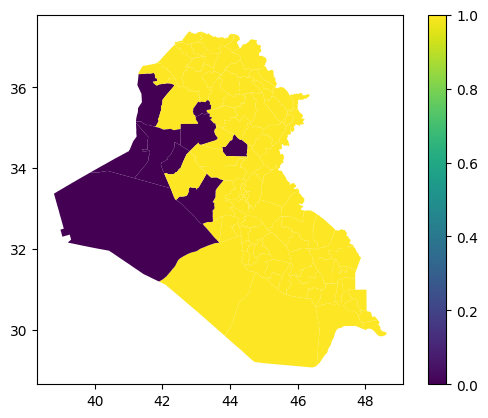

In [64]:
berman_geoepr_comp_suncomp.plot(column='geoepr_ber_agree',legend=True)

<Axes: >

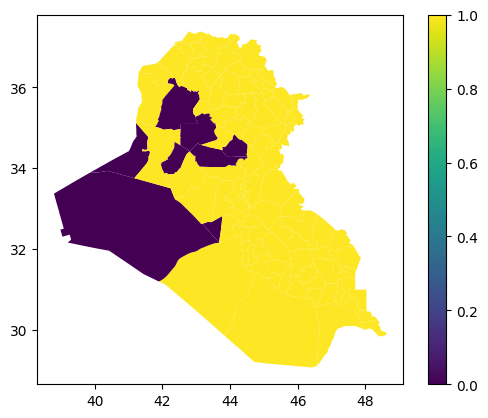

In [65]:
berman_geoepr_comp_suncomp.plot(column='geoepr_cia_agree',legend=True)

<Axes: >

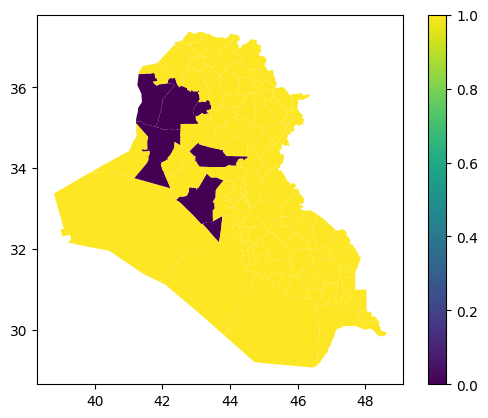

In [66]:
berman_geoepr_comp_suncomp.plot(column='ber_cia_agree',legend=True)

<Axes: >

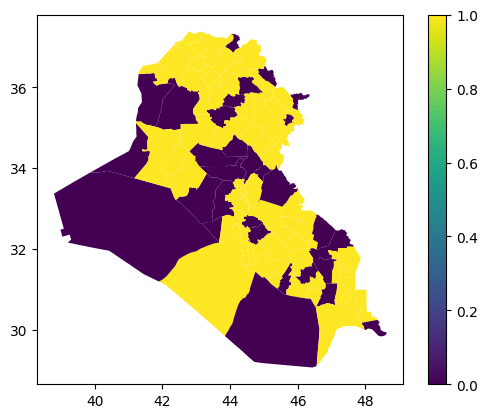

In [107]:
berman_geoepr_comp_suncomp.plot(column='iom_ber_agree',legend=True)